In [1]:
!pip install catboost
!pip install nb_black

     |████████████████████████████████| 12.7MB 11.2MB/s eta 0:00:01
     |████████████████████████████████| 51kB 5.2MB/s eta 0:00:011
     |████████████████████████████████| 27.7MB 14.9MB/s eta 0:00:01    |█                               | 819kB 16.4MB/s eta 0:00:02


In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import sys

import catboost as cb

wids_path = "/Users/diana/Documents/projects/widsdatathon2022"
sys.path.append(wids_path)

from global_vars import all_feature_columns, response_column
import utils.model_utils as mu
from utils.data_utils import *
from utils.visualize import *
from utils.data_process_utils import *

pd.set_option("display.max_columns", 500)
sns.set_context("talk")

#### read in data
test_df = pd.read_csv(f"{wids_path}/data/test.csv")
print(f"Test dimension: {test_df.shape}")
train_df = pd.read_csv(f"{wids_path}/data/train.csv")
print(f"Train dimension: {train_df.shape}")
sample_solution_df = pd.read_csv(f"{wids_path}/data/sample_solution.csv")
print(f"Sample solution dimension: {sample_solution_df.shape}")
train_df.columns = train_df.columns.str.lower()
test_df.columns = test_df.columns.str.lower()

Test dimension: (9705, 63)
Train dimension: (75757, 64)
Sample solution dimension: (9705, 2)


<IPython.core.display.Javascript object>

In [3]:
# Compare train vs test data coverage for diff categories
(
    train_df.groupby(["facility_type"])["id"].count() / train_df["id"].size * 100
).reset_index(name="train_pct").merge(
    (
        test_df.groupby(["facility_type"])["id"].count() / test_df["id"].size * 100
    ).reset_index(name="test_frac"),
    on="facility_type",
    how="outer",
).sort_values(
    "train_pct", ascending=False
)

,facility_type,train_pct,test_frac
27,Multifamily_Uncategorized,52.080996,22.658423
32,Office_Uncategorized,16.515966,19.773313
6,Education_Other_classroom,5.095239,9.170531
21,Lodging_Hotel,2.769381,3.781556
0,2to4_Unit_Building,2.498779,9.953632
2,Commercial_Other,2.302097,3.348789
1,5plus_Unit_Building,1.680373,7.058217
56,Warehouse_Nonrefrigerated,1.656613,1.133436
50,Retail_Uncategorized,1.491611,2.318393
5,Education_College_or_university,1.393931,2.081401


<IPython.core.display.Javascript object>

In [4]:
feature_dict = {
    "base_cat": {
        "cols_to_reduce": [],
        "log10_transform_cols": [],
        "if_one_hot": False,
        "backfill_dict": {},
    },
    "base_onehot": {
        "cols_to_reduce": [],
        "log10_transform_cols": [],
        "if_one_hot": True,
        "backfill_dict": {},
    },
    "log_onehot": {
        "cols_to_reduce": [],
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "backfill_dict": {},
    },
    "log_temp_pca_onehot": {
        "cols_to_reduce": temp_col_list,
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "backfill_dict": {},
    },
    "log_temp_pca_onehot_impute": {
        "cols_to_reduce": temp_col_list,
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "backfill_dict": {
            "energy_star_rating": ["state_factor", "building_class", "facility_type"]
        },
    },
    "log_temp_pca_cat": {
        "cols_to_reduce": temp_col_list,
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": False,
        "backfill_dict": {},
    },
    "log_temp_precip_pca_onehot": {
        "cols_to_reduce": temp_col_list + inch_col_list,
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "backfill_dict": {},
    },
}

<IPython.core.display.Javascript object>

In [5]:
config_name = "base_cat"  # "log_temp_pca_onehot_impute"
cols_to_reduce = feature_dict[config_name]["cols_to_reduce"]
log10_transform_cols = feature_dict[config_name]["log10_transform_cols"]
backfill_dict = feature_dict[config_name]["backfill_dict"]
if_scale = False
if_one_hot = feature_dict[config_name]["if_one_hot"]

# PCA on all of the environmental factor cols!
model = cb.CatBoostRegressor(loss_function="RMSE")

train_filter_df, test_filter_df, pca_cols = process_data(
    train_df.drop_duplicates(),
    test_df.drop_duplicates(),
    cols_to_reduce,
    log10_transform_cols,
    0,
    backfill_dict,
)

<IPython.core.display.Javascript object>

In [6]:
train_filter_df.filter(like="energy_star_rating").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75757 entries, 0 to 75756
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   energy_star_rating  49048 non-null  float64
dtypes: float64(1)
memory usage: 1.2 MB


<IPython.core.display.Javascript object>

In [7]:
# Set feature columns after data transformations
features_columns = (
    list(set(all_feature_columns) - set(cols_to_reduce) - set(log10_transform_cols))
    + pca_cols
    + [f"log10_{col}" for col in log10_transform_cols]
)
if backfill_dict:
    backfill_cols = list(backfill_dict.keys())
    features_columns = list(set(features_columns) - set(backfill_cols)) + [
        f"backfilled_{col}" for col in backfill_cols
    ]
print(config_name, features_columns, if_one_hot)

base_cat ['november_avg_temp', 'energy_star_rating', 'november_max_temp', 'april_avg_temp', 'max_wind_speed', 'may_max_temp', 'direction_max_wind_speed', 'january_min_temp', 'march_max_temp', 'december_avg_temp', 'october_avg_temp', 'april_max_temp', 'july_max_temp', 'direction_peak_wind_speed', 'facility_type', 'year_built', 'building_class', 'march_min_temp', 'march_avg_temp', 'state_factor', 'november_min_temp', 'december_min_temp', 'days_above_110f', 'june_min_temp', 'august_avg_temp', 'september_min_temp', 'october_max_temp', 'days_above_80f', 'july_avg_temp', 'august_min_temp', 'precipitation_inches', 'cooling_degree_days', 'august_max_temp', 'floor_area', 'february_min_temp', 'heating_degree_days', 'avg_temp', 'june_max_temp', 'december_max_temp', 'may_avg_temp', 'july_min_temp', 'september_avg_temp', 'snowdepth_inches', 'october_min_temp', 'may_min_temp', 'january_max_temp', 'elevation', 'snowfall_inches', 'june_avg_temp', 'september_max_temp', 'days_below_20f', 'days_below_30f

<IPython.core.display.Javascript object>

In [8]:
## Run LOY model
catboost_rmse = mu.run_leave_year_out(
    model_df=train_filter_df,
    ml_model=model,
    features_columns=features_columns,
    if_scale_data=if_scale,
    if_one_hot=if_one_hot,
    model_type="catboost",
)
print(f"Average RMSE:\n{catboost_rmse.mean()}")
display(catboost_rmse)

## predict on test data
train_filter_x_df, train_filter_y_df = mu.split_model_feature_response(
    train_filter_df, features_columns
)
test_filter_x_df = mu.split_model_feature_response(
    test_filter_df, features_columns, if_with_response=False
)
processed_train_x_df, processed_test_x_df = mu.process_train_test_data(
    train_filter_x_df, test_filter_x_df, if_scale, if_one_hot,
)

train_predict, test_predict = mu.run_catboost_model(
    model, processed_train_x_df, train_filter_y_df, processed_test_x_df
)
training_rmse = mu.calculate_rmse(train_filter_y_df, train_predict)
print(f"Whole data train RMSE: {training_rmse}")

## output save result
catboost_rmse.loc[catboost_rmse.shape[0], :] = [0, training_rmse, np.nan]
catboost_rmse["method"] = catboost_rmse["left_out_year"].apply(
    lambda x: "loyo" if x > 0 else "whole train"
)
display(catboost_rmse)
catboost_rmse.to_csv(f"{wids_path}/validation_result/{config_name}.csv", index=False)

test_prediction_result = test_df[["id"]]
test_prediction_result["site_eui"] = test_predict
test_prediction_result.to_csv(
    f"{wids_path}/prediction_result/{config_name}.csv", index=False
)

Running catboost
Modeling 1...
Learning rate set to 0.080758
0:	learn: 56.2393654	total: 99ms	remaining: 1m 38s
1:	learn: 55.0655796	total: 143ms	remaining: 1m 11s
2:	learn: 54.1872898	total: 192ms	remaining: 1m 3s
3:	learn: 53.2305985	total: 239ms	remaining: 59.5s
4:	learn: 52.5843584	total: 281ms	remaining: 55.9s
5:	learn: 51.8556814	total: 328ms	remaining: 54.3s
6:	learn: 51.2207920	total: 364ms	remaining: 51.7s
7:	learn: 50.7644286	total: 411ms	remaining: 51s
8:	learn: 50.2349414	total: 458ms	remaining: 50.4s
9:	learn: 49.7454420	total: 501ms	remaining: 49.6s
10:	learn: 49.4134140	total: 536ms	remaining: 48.2s
11:	learn: 49.0074250	total: 573ms	remaining: 47.2s
12:	learn: 48.7005668	total: 620ms	remaining: 47s
13:	learn: 48.4739441	total: 739ms	remaining: 52.1s
14:	learn: 48.1720569	total: 813ms	remaining: 53.4s
15:	learn: 47.9026184	total: 895ms	remaining: 55s
16:	learn: 47.6715194	total: 957ms	remaining: 55.3s
17:	learn: 47.5201413	total: 995ms	remaining: 54.3s
18:	learn: 47.3035

162:	learn: 42.5473643	total: 6.89s	remaining: 35.4s
163:	learn: 42.5426357	total: 6.93s	remaining: 35.3s
164:	learn: 42.5307848	total: 6.96s	remaining: 35.2s
165:	learn: 42.5234725	total: 6.99s	remaining: 35.1s
166:	learn: 42.5083736	total: 7.02s	remaining: 35s
167:	learn: 42.5044685	total: 7.05s	remaining: 34.9s
168:	learn: 42.4930794	total: 7.08s	remaining: 34.8s
169:	learn: 42.4893668	total: 7.12s	remaining: 34.8s
170:	learn: 42.4775206	total: 7.15s	remaining: 34.7s
171:	learn: 42.4559259	total: 7.18s	remaining: 34.6s
172:	learn: 42.4514520	total: 7.22s	remaining: 34.5s
173:	learn: 42.4310974	total: 7.25s	remaining: 34.4s
174:	learn: 42.4277629	total: 7.28s	remaining: 34.3s
175:	learn: 42.4271374	total: 7.31s	remaining: 34.2s
176:	learn: 42.4072061	total: 7.35s	remaining: 34.2s
177:	learn: 42.4042600	total: 7.38s	remaining: 34.1s
178:	learn: 42.3873067	total: 7.42s	remaining: 34s
179:	learn: 42.3734904	total: 7.45s	remaining: 33.9s
180:	learn: 42.3666620	total: 7.48s	remaining: 33.

324:	learn: 41.2620633	total: 12.4s	remaining: 25.7s
325:	learn: 41.2539395	total: 12.4s	remaining: 25.6s
326:	learn: 41.2338689	total: 12.4s	remaining: 25.6s
327:	learn: 41.2283305	total: 12.4s	remaining: 25.5s
328:	learn: 41.2259801	total: 12.5s	remaining: 25.4s
329:	learn: 41.2093153	total: 12.5s	remaining: 25.4s
330:	learn: 41.2080896	total: 12.5s	remaining: 25.3s
331:	learn: 41.2024139	total: 12.6s	remaining: 25.3s
332:	learn: 41.1911812	total: 12.6s	remaining: 25.2s
333:	learn: 41.1803250	total: 12.6s	remaining: 25.2s
334:	learn: 41.1776337	total: 12.7s	remaining: 25.1s
335:	learn: 41.1755384	total: 12.7s	remaining: 25.1s
336:	learn: 41.1662364	total: 12.7s	remaining: 25.1s
337:	learn: 41.1615851	total: 12.8s	remaining: 25s
338:	learn: 41.1467862	total: 12.8s	remaining: 25s
339:	learn: 41.1415867	total: 12.8s	remaining: 24.9s
340:	learn: 41.1326320	total: 12.9s	remaining: 24.9s
341:	learn: 41.1294676	total: 12.9s	remaining: 24.8s
342:	learn: 41.1238955	total: 12.9s	remaining: 24.

483:	learn: 40.2674474	total: 18s	remaining: 19.2s
484:	learn: 40.2594907	total: 18s	remaining: 19.1s
485:	learn: 40.2541859	total: 18.1s	remaining: 19.1s
486:	learn: 40.2526025	total: 18.1s	remaining: 19.1s
487:	learn: 40.2456464	total: 18.1s	remaining: 19s
488:	learn: 40.2390943	total: 18.1s	remaining: 19s
489:	learn: 40.2331160	total: 18.2s	remaining: 18.9s
490:	learn: 40.2301379	total: 18.2s	remaining: 18.9s
491:	learn: 40.2225711	total: 18.2s	remaining: 18.8s
492:	learn: 40.2158366	total: 18.3s	remaining: 18.8s
493:	learn: 40.2122861	total: 18.3s	remaining: 18.7s
494:	learn: 40.2115281	total: 18.3s	remaining: 18.7s
495:	learn: 40.2087525	total: 18.3s	remaining: 18.6s
496:	learn: 40.2031314	total: 18.4s	remaining: 18.6s
497:	learn: 40.1969337	total: 18.4s	remaining: 18.6s
498:	learn: 40.1871957	total: 18.4s	remaining: 18.5s
499:	learn: 40.1861512	total: 18.5s	remaining: 18.5s
500:	learn: 40.1851965	total: 18.5s	remaining: 18.4s
501:	learn: 40.1765520	total: 18.5s	remaining: 18.4s
5

640:	learn: 39.5398169	total: 22.9s	remaining: 12.9s
641:	learn: 39.5311717	total: 23s	remaining: 12.8s
642:	learn: 39.5244221	total: 23s	remaining: 12.8s
643:	learn: 39.5212581	total: 23s	remaining: 12.7s
644:	learn: 39.5138338	total: 23.1s	remaining: 12.7s
645:	learn: 39.5115361	total: 23.1s	remaining: 12.7s
646:	learn: 39.5103343	total: 23.1s	remaining: 12.6s
647:	learn: 39.5047214	total: 23.2s	remaining: 12.6s
648:	learn: 39.5016200	total: 23.2s	remaining: 12.5s
649:	learn: 39.5009707	total: 23.2s	remaining: 12.5s
650:	learn: 39.4970606	total: 23.3s	remaining: 12.5s
651:	learn: 39.4933512	total: 23.3s	remaining: 12.4s
652:	learn: 39.4865428	total: 23.3s	remaining: 12.4s
653:	learn: 39.4810082	total: 23.4s	remaining: 12.4s
654:	learn: 39.4734321	total: 23.4s	remaining: 12.3s
655:	learn: 39.4726847	total: 23.4s	remaining: 12.3s
656:	learn: 39.4721065	total: 23.4s	remaining: 12.2s
657:	learn: 39.4709753	total: 23.5s	remaining: 12.2s
658:	learn: 39.4704678	total: 23.5s	remaining: 12.2s

796:	learn: 38.9229249	total: 28.7s	remaining: 7.31s
797:	learn: 38.9222338	total: 28.7s	remaining: 7.27s
798:	learn: 38.9194154	total: 28.8s	remaining: 7.23s
799:	learn: 38.9191346	total: 28.8s	remaining: 7.2s
800:	learn: 38.9166121	total: 28.8s	remaining: 7.16s
801:	learn: 38.9163627	total: 28.9s	remaining: 7.12s
802:	learn: 38.9143278	total: 28.9s	remaining: 7.09s
803:	learn: 38.9042805	total: 28.9s	remaining: 7.05s
804:	learn: 38.8921566	total: 29s	remaining: 7.02s
805:	learn: 38.8868736	total: 29s	remaining: 6.98s
806:	learn: 38.8854075	total: 29s	remaining: 6.95s
807:	learn: 38.8844260	total: 29.1s	remaining: 6.91s
808:	learn: 38.8792406	total: 29.1s	remaining: 6.87s
809:	learn: 38.8774154	total: 29.1s	remaining: 6.83s
810:	learn: 38.8696939	total: 29.2s	remaining: 6.8s
811:	learn: 38.8695748	total: 29.2s	remaining: 6.76s
812:	learn: 38.8695298	total: 29.2s	remaining: 6.72s
813:	learn: 38.8659550	total: 29.3s	remaining: 6.69s
814:	learn: 38.8594592	total: 29.3s	remaining: 6.66s
8

952:	learn: 38.2887784	total: 34.6s	remaining: 1.71s
953:	learn: 38.2868932	total: 34.6s	remaining: 1.67s
954:	learn: 38.2822224	total: 34.7s	remaining: 1.63s
955:	learn: 38.2726187	total: 34.8s	remaining: 1.6s
956:	learn: 38.2673668	total: 34.8s	remaining: 1.56s
957:	learn: 38.2651152	total: 34.9s	remaining: 1.53s
958:	learn: 38.2611566	total: 34.9s	remaining: 1.49s
959:	learn: 38.2568619	total: 34.9s	remaining: 1.46s
960:	learn: 38.2548786	total: 35s	remaining: 1.42s
961:	learn: 38.2533184	total: 35s	remaining: 1.38s
962:	learn: 38.2532210	total: 35s	remaining: 1.34s
963:	learn: 38.2442327	total: 35.1s	remaining: 1.31s
964:	learn: 38.2431313	total: 35.1s	remaining: 1.27s
965:	learn: 38.2430514	total: 35.1s	remaining: 1.24s
966:	learn: 38.2401336	total: 35.2s	remaining: 1.2s
967:	learn: 38.2399891	total: 35.2s	remaining: 1.16s
968:	learn: 38.2329278	total: 35.2s	remaining: 1.13s
969:	learn: 38.2282945	total: 35.3s	remaining: 1.09s
970:	learn: 38.2241990	total: 35.3s	remaining: 1.05s
9

114:	learn: 43.3948734	total: 5.46s	remaining: 42.1s
115:	learn: 43.3843185	total: 5.53s	remaining: 42.2s
116:	learn: 43.3723456	total: 5.58s	remaining: 42.1s
117:	learn: 43.3535665	total: 5.64s	remaining: 42.2s
118:	learn: 43.3495439	total: 5.71s	remaining: 42.3s
119:	learn: 43.3374420	total: 5.77s	remaining: 42.3s
120:	learn: 43.3154350	total: 5.82s	remaining: 42.3s
121:	learn: 43.3101049	total: 5.86s	remaining: 42.2s
122:	learn: 43.3027232	total: 5.9s	remaining: 42.1s
123:	learn: 43.2837369	total: 5.96s	remaining: 42.1s
124:	learn: 43.2733142	total: 6.02s	remaining: 42.2s
125:	learn: 43.2549987	total: 6.08s	remaining: 42.2s
126:	learn: 43.2354859	total: 6.11s	remaining: 42s
127:	learn: 43.2220543	total: 6.17s	remaining: 42s
128:	learn: 43.2084665	total: 6.23s	remaining: 42s
129:	learn: 43.1742588	total: 6.29s	remaining: 42.1s
130:	learn: 43.1664651	total: 6.32s	remaining: 41.9s
131:	learn: 43.1534949	total: 6.36s	remaining: 41.8s
132:	learn: 43.1397152	total: 6.4s	remaining: 41.7s
1

273:	learn: 41.5423459	total: 12s	remaining: 31.7s
274:	learn: 41.5377944	total: 12s	remaining: 31.7s
275:	learn: 41.5337640	total: 12.1s	remaining: 31.7s
276:	learn: 41.5221576	total: 12.1s	remaining: 31.6s
277:	learn: 41.5124178	total: 12.1s	remaining: 31.5s
278:	learn: 41.4994176	total: 12.2s	remaining: 31.4s
279:	learn: 41.4958347	total: 12.2s	remaining: 31.4s
280:	learn: 41.4886579	total: 12.2s	remaining: 31.3s
281:	learn: 41.4691812	total: 12.3s	remaining: 31.2s
282:	learn: 41.4482517	total: 12.3s	remaining: 31.2s
283:	learn: 41.4362931	total: 12.3s	remaining: 31.1s
284:	learn: 41.4345023	total: 12.4s	remaining: 31.1s
285:	learn: 41.4181216	total: 12.4s	remaining: 31s
286:	learn: 41.4149905	total: 12.4s	remaining: 30.9s
287:	learn: 41.4041189	total: 12.5s	remaining: 30.8s
288:	learn: 41.3819423	total: 12.5s	remaining: 30.8s
289:	learn: 41.3784245	total: 12.5s	remaining: 30.7s
290:	learn: 41.3744267	total: 12.6s	remaining: 30.7s
291:	learn: 41.3474409	total: 12.6s	remaining: 30.6s

432:	learn: 40.3217087	total: 18s	remaining: 23.5s
433:	learn: 40.3097707	total: 18s	remaining: 23.5s
434:	learn: 40.3087068	total: 18s	remaining: 23.4s
435:	learn: 40.3050373	total: 18.1s	remaining: 23.4s
436:	learn: 40.3046136	total: 18.1s	remaining: 23.3s
437:	learn: 40.3028978	total: 18.1s	remaining: 23.3s
438:	learn: 40.3023908	total: 18.2s	remaining: 23.2s
439:	learn: 40.2954698	total: 18.2s	remaining: 23.1s
440:	learn: 40.2949748	total: 18.2s	remaining: 23.1s
441:	learn: 40.2923567	total: 18.3s	remaining: 23s
442:	learn: 40.2903149	total: 18.3s	remaining: 23s
443:	learn: 40.2820577	total: 18.3s	remaining: 22.9s
444:	learn: 40.2798364	total: 18.3s	remaining: 22.9s
445:	learn: 40.2778748	total: 18.4s	remaining: 22.8s
446:	learn: 40.2668499	total: 18.4s	remaining: 22.8s
447:	learn: 40.2565934	total: 18.4s	remaining: 22.7s
448:	learn: 40.2527353	total: 18.5s	remaining: 22.7s
449:	learn: 40.2452294	total: 18.5s	remaining: 22.6s
450:	learn: 40.2363078	total: 18.5s	remaining: 22.6s
451

594:	learn: 39.6160868	total: 23.1s	remaining: 15.7s
595:	learn: 39.6145475	total: 23.2s	remaining: 15.7s
596:	learn: 39.6089069	total: 23.2s	remaining: 15.7s
597:	learn: 39.6069723	total: 23.3s	remaining: 15.6s
598:	learn: 39.6012895	total: 23.3s	remaining: 15.6s
599:	learn: 39.5991039	total: 23.3s	remaining: 15.6s
600:	learn: 39.5932255	total: 23.4s	remaining: 15.5s
601:	learn: 39.5843492	total: 23.4s	remaining: 15.5s
602:	learn: 39.5825483	total: 23.4s	remaining: 15.4s
603:	learn: 39.5789133	total: 23.5s	remaining: 15.4s
604:	learn: 39.5778023	total: 23.5s	remaining: 15.3s
605:	learn: 39.5771396	total: 23.6s	remaining: 15.3s
606:	learn: 39.5722599	total: 23.6s	remaining: 15.3s
607:	learn: 39.5627458	total: 23.6s	remaining: 15.2s
608:	learn: 39.5621999	total: 23.7s	remaining: 15.2s
609:	learn: 39.5500565	total: 23.7s	remaining: 15.2s
610:	learn: 39.5470723	total: 23.8s	remaining: 15.1s
611:	learn: 39.5381203	total: 23.8s	remaining: 15.1s
612:	learn: 39.5335082	total: 23.8s	remaining:

751:	learn: 38.9320088	total: 29.8s	remaining: 9.83s
752:	learn: 38.9274456	total: 29.9s	remaining: 9.79s
753:	learn: 38.9092451	total: 29.9s	remaining: 9.75s
754:	learn: 38.9064091	total: 29.9s	remaining: 9.71s
755:	learn: 38.9046865	total: 30s	remaining: 9.67s
756:	learn: 38.8937675	total: 30s	remaining: 9.63s
757:	learn: 38.8925956	total: 30.1s	remaining: 9.6s
758:	learn: 38.8803729	total: 30.1s	remaining: 9.56s
759:	learn: 38.8762838	total: 30.2s	remaining: 9.52s
760:	learn: 38.8733991	total: 30.2s	remaining: 9.48s
761:	learn: 38.8703443	total: 30.2s	remaining: 9.45s
762:	learn: 38.8646574	total: 30.3s	remaining: 9.4s
763:	learn: 38.8562070	total: 30.3s	remaining: 9.37s
764:	learn: 38.8472802	total: 30.4s	remaining: 9.33s
765:	learn: 38.8415337	total: 30.4s	remaining: 9.29s
766:	learn: 38.8299312	total: 30.5s	remaining: 9.25s
767:	learn: 38.8275364	total: 30.5s	remaining: 9.21s
768:	learn: 38.8257899	total: 30.5s	remaining: 9.17s
769:	learn: 38.8247473	total: 30.6s	remaining: 9.13s

911:	learn: 38.2345784	total: 36.1s	remaining: 3.48s
912:	learn: 38.2311053	total: 36.1s	remaining: 3.44s
913:	learn: 38.2281856	total: 36.1s	remaining: 3.4s
914:	learn: 38.2247447	total: 36.2s	remaining: 3.36s
915:	learn: 38.2232315	total: 36.2s	remaining: 3.32s
916:	learn: 38.2201552	total: 36.2s	remaining: 3.28s
917:	learn: 38.2142621	total: 36.3s	remaining: 3.24s
918:	learn: 38.2108250	total: 36.3s	remaining: 3.2s
919:	learn: 38.2089833	total: 36.4s	remaining: 3.16s
920:	learn: 38.2042883	total: 36.4s	remaining: 3.12s
921:	learn: 38.2022350	total: 36.4s	remaining: 3.08s
922:	learn: 38.2016579	total: 36.5s	remaining: 3.04s
923:	learn: 38.1987455	total: 36.5s	remaining: 3s
924:	learn: 38.1975892	total: 36.5s	remaining: 2.96s
925:	learn: 38.1970381	total: 36.6s	remaining: 2.92s
926:	learn: 38.1966386	total: 36.6s	remaining: 2.88s
927:	learn: 38.1927959	total: 36.6s	remaining: 2.84s
928:	learn: 38.1844454	total: 36.7s	remaining: 2.8s
929:	learn: 38.1812340	total: 36.7s	remaining: 2.76s

68:	learn: 43.5509465	total: 2.57s	remaining: 34.7s
69:	learn: 43.5180807	total: 2.61s	remaining: 34.7s
70:	learn: 43.5047505	total: 2.65s	remaining: 34.7s
71:	learn: 43.4688709	total: 2.69s	remaining: 34.6s
72:	learn: 43.4455052	total: 2.72s	remaining: 34.5s
73:	learn: 43.4123052	total: 2.75s	remaining: 34.5s
74:	learn: 43.3995395	total: 2.79s	remaining: 34.4s
75:	learn: 43.3931003	total: 2.82s	remaining: 34.3s
76:	learn: 43.3793685	total: 2.86s	remaining: 34.3s
77:	learn: 43.3610646	total: 2.89s	remaining: 34.1s
78:	learn: 43.3453058	total: 2.92s	remaining: 34.1s
79:	learn: 43.3217173	total: 2.97s	remaining: 34.1s
80:	learn: 43.2853952	total: 3.01s	remaining: 34.2s
81:	learn: 43.2414293	total: 3.06s	remaining: 34.3s
82:	learn: 43.2034169	total: 3.11s	remaining: 34.4s
83:	learn: 43.1933805	total: 3.15s	remaining: 34.4s
84:	learn: 43.1866190	total: 3.18s	remaining: 34.3s
85:	learn: 43.1829309	total: 3.21s	remaining: 34.1s
86:	learn: 43.1650824	total: 3.25s	remaining: 34.1s
87:	learn: 4

228:	learn: 41.4150732	total: 7.97s	remaining: 26.9s
229:	learn: 41.4093074	total: 8.01s	remaining: 26.8s
230:	learn: 41.4022322	total: 8.05s	remaining: 26.8s
231:	learn: 41.3881666	total: 8.07s	remaining: 26.7s
232:	learn: 41.3830259	total: 8.1s	remaining: 26.7s
233:	learn: 41.3677176	total: 8.13s	remaining: 26.6s
234:	learn: 41.3594616	total: 8.17s	remaining: 26.6s
235:	learn: 41.3582387	total: 8.21s	remaining: 26.6s
236:	learn: 41.3548032	total: 8.24s	remaining: 26.5s
237:	learn: 41.3544772	total: 8.27s	remaining: 26.5s
238:	learn: 41.3450845	total: 8.3s	remaining: 26.4s
239:	learn: 41.3445113	total: 8.32s	remaining: 26.4s
240:	learn: 41.3324277	total: 8.36s	remaining: 26.3s
241:	learn: 41.3172934	total: 8.4s	remaining: 26.3s
242:	learn: 41.2997817	total: 8.43s	remaining: 26.3s
243:	learn: 41.2975626	total: 8.46s	remaining: 26.2s
244:	learn: 41.2894739	total: 8.49s	remaining: 26.2s
245:	learn: 41.2873054	total: 8.52s	remaining: 26.1s
246:	learn: 41.2836737	total: 8.55s	remaining: 26

384:	learn: 40.2018284	total: 13.5s	remaining: 21.6s
385:	learn: 40.1980291	total: 13.5s	remaining: 21.5s
386:	learn: 40.1965273	total: 13.6s	remaining: 21.5s
387:	learn: 40.1898209	total: 13.6s	remaining: 21.4s
388:	learn: 40.1888283	total: 13.6s	remaining: 21.4s
389:	learn: 40.1779222	total: 13.7s	remaining: 21.4s
390:	learn: 40.1656160	total: 13.7s	remaining: 21.3s
391:	learn: 40.1531516	total: 13.7s	remaining: 21.3s
392:	learn: 40.1469178	total: 13.8s	remaining: 21.3s
393:	learn: 40.1439586	total: 13.8s	remaining: 21.2s
394:	learn: 40.1382465	total: 13.8s	remaining: 21.2s
395:	learn: 40.1253516	total: 13.9s	remaining: 21.2s
396:	learn: 40.1097881	total: 13.9s	remaining: 21.1s
397:	learn: 40.1024644	total: 14s	remaining: 21.1s
398:	learn: 40.0989597	total: 14s	remaining: 21.1s
399:	learn: 40.0931557	total: 14s	remaining: 21s
400:	learn: 40.0870892	total: 14.1s	remaining: 21s
401:	learn: 40.0805020	total: 14.1s	remaining: 21s
402:	learn: 40.0742797	total: 14.1s	remaining: 21s
403:	le

541:	learn: 39.2002389	total: 19.5s	remaining: 16.5s
542:	learn: 39.1964832	total: 19.5s	remaining: 16.4s
543:	learn: 39.1929067	total: 19.6s	remaining: 16.4s
544:	learn: 39.1855220	total: 19.6s	remaining: 16.4s
545:	learn: 39.1802059	total: 19.7s	remaining: 16.4s
546:	learn: 39.1790784	total: 19.7s	remaining: 16.3s
547:	learn: 39.1757462	total: 19.8s	remaining: 16.3s
548:	learn: 39.1646631	total: 19.8s	remaining: 16.3s
549:	learn: 39.1602512	total: 19.8s	remaining: 16.2s
550:	learn: 39.1565365	total: 19.9s	remaining: 16.2s
551:	learn: 39.1305601	total: 19.9s	remaining: 16.1s
552:	learn: 39.1289754	total: 19.9s	remaining: 16.1s
553:	learn: 39.1181284	total: 20s	remaining: 16.1s
554:	learn: 39.1067826	total: 20s	remaining: 16s
555:	learn: 39.1050226	total: 20s	remaining: 16s
556:	learn: 39.0979480	total: 20.1s	remaining: 16s
557:	learn: 39.0956237	total: 20.1s	remaining: 15.9s
558:	learn: 39.0910335	total: 20.1s	remaining: 15.9s
559:	learn: 39.0906179	total: 20.2s	remaining: 15.8s
560:	

699:	learn: 38.3835673	total: 25s	remaining: 10.7s
700:	learn: 38.3819116	total: 25s	remaining: 10.7s
701:	learn: 38.3659976	total: 25.1s	remaining: 10.6s
702:	learn: 38.3654489	total: 25.1s	remaining: 10.6s
703:	learn: 38.3612222	total: 25.1s	remaining: 10.6s
704:	learn: 38.3520037	total: 25.2s	remaining: 10.5s
705:	learn: 38.3457481	total: 25.2s	remaining: 10.5s
706:	learn: 38.3397929	total: 25.2s	remaining: 10.5s
707:	learn: 38.3366920	total: 25.3s	remaining: 10.4s
708:	learn: 38.3279599	total: 25.3s	remaining: 10.4s
709:	learn: 38.3242274	total: 25.3s	remaining: 10.3s
710:	learn: 38.3236800	total: 25.4s	remaining: 10.3s
711:	learn: 38.3233122	total: 25.4s	remaining: 10.3s
712:	learn: 38.3181372	total: 25.4s	remaining: 10.2s
713:	learn: 38.3179748	total: 25.4s	remaining: 10.2s
714:	learn: 38.3174952	total: 25.4s	remaining: 10.1s
715:	learn: 38.3113787	total: 25.5s	remaining: 10.1s
716:	learn: 38.2971238	total: 25.5s	remaining: 10.1s
717:	learn: 38.2956263	total: 25.5s	remaining: 10s

858:	learn: 37.7454392	total: 30.1s	remaining: 4.94s
859:	learn: 37.7416219	total: 30.1s	remaining: 4.9s
860:	learn: 37.7350692	total: 30.2s	remaining: 4.87s
861:	learn: 37.7317867	total: 30.2s	remaining: 4.83s
862:	learn: 37.7310658	total: 30.2s	remaining: 4.8s
863:	learn: 37.7251974	total: 30.3s	remaining: 4.76s
864:	learn: 37.7221930	total: 30.3s	remaining: 4.73s
865:	learn: 37.7134651	total: 30.3s	remaining: 4.7s
866:	learn: 37.7115292	total: 30.4s	remaining: 4.66s
867:	learn: 37.7019631	total: 30.4s	remaining: 4.63s
868:	learn: 37.6942716	total: 30.5s	remaining: 4.59s
869:	learn: 37.6900821	total: 30.5s	remaining: 4.55s
870:	learn: 37.6881591	total: 30.5s	remaining: 4.52s
871:	learn: 37.6816254	total: 30.6s	remaining: 4.48s
872:	learn: 37.6778818	total: 30.6s	remaining: 4.45s
873:	learn: 37.6737197	total: 30.6s	remaining: 4.41s
874:	learn: 37.6706645	total: 30.6s	remaining: 4.38s
875:	learn: 37.6704898	total: 30.7s	remaining: 4.34s
876:	learn: 37.6588841	total: 30.7s	remaining: 4.

13:	learn: 49.4885717	total: 507ms	remaining: 35.7s
14:	learn: 49.1732546	total: 542ms	remaining: 35.6s
15:	learn: 48.8865077	total: 573ms	remaining: 35.3s
16:	learn: 48.6876203	total: 599ms	remaining: 34.6s
17:	learn: 48.5042034	total: 630ms	remaining: 34.4s
18:	learn: 48.2907987	total: 660ms	remaining: 34.1s
19:	learn: 48.0224748	total: 702ms	remaining: 34.4s
20:	learn: 47.9028581	total: 735ms	remaining: 34.3s
21:	learn: 47.7198330	total: 766ms	remaining: 34s
22:	learn: 47.5216836	total: 802ms	remaining: 34.1s
23:	learn: 47.3997695	total: 830ms	remaining: 33.8s
24:	learn: 47.2827266	total: 860ms	remaining: 33.5s
25:	learn: 47.2168652	total: 887ms	remaining: 33.2s
26:	learn: 47.0809609	total: 918ms	remaining: 33.1s
27:	learn: 46.9935715	total: 954ms	remaining: 33.1s
28:	learn: 46.8621332	total: 992ms	remaining: 33.2s
29:	learn: 46.7483051	total: 1.03s	remaining: 33.2s
30:	learn: 46.7018018	total: 1.06s	remaining: 33s
31:	learn: 46.6271406	total: 1.08s	remaining: 32.7s
32:	learn: 46.57

174:	learn: 43.3537427	total: 5.85s	remaining: 27.6s
175:	learn: 43.3363770	total: 5.88s	remaining: 27.5s
176:	learn: 43.3209468	total: 5.9s	remaining: 27.4s
177:	learn: 43.3150841	total: 5.93s	remaining: 27.4s
178:	learn: 43.3049134	total: 5.95s	remaining: 27.3s
179:	learn: 43.2999657	total: 5.98s	remaining: 27.3s
180:	learn: 43.2908593	total: 6.01s	remaining: 27.2s
181:	learn: 43.2820358	total: 6.03s	remaining: 27.1s
182:	learn: 43.2744949	total: 6.06s	remaining: 27.1s
183:	learn: 43.2679105	total: 6.09s	remaining: 27s
184:	learn: 43.2407044	total: 6.12s	remaining: 27s
185:	learn: 43.2338384	total: 6.15s	remaining: 26.9s
186:	learn: 43.2156908	total: 6.18s	remaining: 26.9s
187:	learn: 43.2050674	total: 6.21s	remaining: 26.8s
188:	learn: 43.1929815	total: 6.23s	remaining: 26.7s
189:	learn: 43.1829921	total: 6.26s	remaining: 26.7s
190:	learn: 43.1622124	total: 6.29s	remaining: 26.6s
191:	learn: 43.1425624	total: 6.32s	remaining: 26.6s
192:	learn: 43.1382722	total: 6.35s	remaining: 26.5

333:	learn: 41.7979133	total: 12.1s	remaining: 24.1s
334:	learn: 41.7937211	total: 12.1s	remaining: 24.1s
335:	learn: 41.7857494	total: 12.2s	remaining: 24.1s
336:	learn: 41.7788608	total: 12.2s	remaining: 24s
337:	learn: 41.7767597	total: 12.3s	remaining: 24s
338:	learn: 41.7723796	total: 12.3s	remaining: 24.1s
339:	learn: 41.7532519	total: 12.4s	remaining: 24.1s
340:	learn: 41.7474766	total: 12.5s	remaining: 24.1s
341:	learn: 41.7436560	total: 12.5s	remaining: 24.1s
342:	learn: 41.7359628	total: 12.6s	remaining: 24s
343:	learn: 41.7287452	total: 12.6s	remaining: 24s
344:	learn: 41.7275316	total: 12.6s	remaining: 24s
345:	learn: 41.7135431	total: 12.7s	remaining: 24s
346:	learn: 41.7047447	total: 12.7s	remaining: 23.9s
347:	learn: 41.7044218	total: 12.7s	remaining: 23.9s
348:	learn: 41.7029698	total: 12.8s	remaining: 23.8s
349:	learn: 41.7002061	total: 12.8s	remaining: 23.8s
350:	learn: 41.6770143	total: 12.9s	remaining: 23.8s
351:	learn: 41.6740606	total: 12.9s	remaining: 23.7s
352:	

491:	learn: 40.8783414	total: 17.4s	remaining: 18s
492:	learn: 40.8674754	total: 17.5s	remaining: 18s
493:	learn: 40.8637073	total: 17.5s	remaining: 17.9s
494:	learn: 40.8606254	total: 17.6s	remaining: 17.9s
495:	learn: 40.8504364	total: 17.6s	remaining: 17.9s
496:	learn: 40.8396123	total: 17.6s	remaining: 17.8s
497:	learn: 40.8339401	total: 17.7s	remaining: 17.8s
498:	learn: 40.8309107	total: 17.7s	remaining: 17.8s
499:	learn: 40.8237884	total: 17.7s	remaining: 17.7s
500:	learn: 40.8171771	total: 17.8s	remaining: 17.7s
501:	learn: 40.8171422	total: 17.8s	remaining: 17.6s
502:	learn: 40.8061003	total: 17.8s	remaining: 17.6s
503:	learn: 40.8028784	total: 17.8s	remaining: 17.6s
504:	learn: 40.8010330	total: 17.9s	remaining: 17.5s
505:	learn: 40.7952259	total: 17.9s	remaining: 17.5s
506:	learn: 40.7937549	total: 17.9s	remaining: 17.4s
507:	learn: 40.7864816	total: 17.9s	remaining: 17.4s
508:	learn: 40.7851583	total: 18s	remaining: 17.3s
509:	learn: 40.7848824	total: 18s	remaining: 17.3s
5

648:	learn: 40.0772490	total: 22.2s	remaining: 12s
649:	learn: 40.0738743	total: 22.2s	remaining: 12s
650:	learn: 40.0733113	total: 22.3s	remaining: 11.9s
651:	learn: 40.0678603	total: 22.3s	remaining: 11.9s
652:	learn: 40.0633156	total: 22.3s	remaining: 11.9s
653:	learn: 40.0595271	total: 22.3s	remaining: 11.8s
654:	learn: 40.0551271	total: 22.4s	remaining: 11.8s
655:	learn: 40.0489176	total: 22.4s	remaining: 11.7s
656:	learn: 40.0474700	total: 22.4s	remaining: 11.7s
657:	learn: 40.0429497	total: 22.5s	remaining: 11.7s
658:	learn: 40.0424372	total: 22.5s	remaining: 11.6s
659:	learn: 40.0362725	total: 22.5s	remaining: 11.6s
660:	learn: 40.0323923	total: 22.5s	remaining: 11.6s
661:	learn: 40.0295958	total: 22.6s	remaining: 11.5s
662:	learn: 40.0193659	total: 22.6s	remaining: 11.5s
663:	learn: 40.0146005	total: 22.6s	remaining: 11.5s
664:	learn: 40.0130374	total: 22.7s	remaining: 11.4s
665:	learn: 40.0091591	total: 22.7s	remaining: 11.4s
666:	learn: 40.0029608	total: 22.7s	remaining: 11.

810:	learn: 39.3686089	total: 26.9s	remaining: 6.26s
811:	learn: 39.3647842	total: 26.9s	remaining: 6.22s
812:	learn: 39.3605527	total: 26.9s	remaining: 6.19s
813:	learn: 39.3604238	total: 26.9s	remaining: 6.15s
814:	learn: 39.3544683	total: 26.9s	remaining: 6.12s
815:	learn: 39.3463932	total: 27s	remaining: 6.08s
816:	learn: 39.3432186	total: 27s	remaining: 6.05s
817:	learn: 39.3403085	total: 27s	remaining: 6.01s
818:	learn: 39.3350150	total: 27.1s	remaining: 5.98s
819:	learn: 39.3292770	total: 27.1s	remaining: 5.95s
820:	learn: 39.3261468	total: 27.1s	remaining: 5.91s
821:	learn: 39.3224626	total: 27.1s	remaining: 5.88s
822:	learn: 39.3189173	total: 27.2s	remaining: 5.84s
823:	learn: 39.3165562	total: 27.2s	remaining: 5.81s
824:	learn: 39.3150204	total: 27.2s	remaining: 5.77s
825:	learn: 39.3124776	total: 27.3s	remaining: 5.74s
826:	learn: 39.3072032	total: 27.3s	remaining: 5.71s
827:	learn: 39.3022217	total: 27.3s	remaining: 5.67s
828:	learn: 39.3013135	total: 27.3s	remaining: 5.64s

969:	learn: 38.7395726	total: 32.1s	remaining: 993ms
970:	learn: 38.7385398	total: 32.1s	remaining: 960ms
971:	learn: 38.7295425	total: 32.2s	remaining: 928ms
972:	learn: 38.7267015	total: 32.2s	remaining: 895ms
973:	learn: 38.7222003	total: 32.3s	remaining: 862ms
974:	learn: 38.7210794	total: 32.3s	remaining: 829ms
975:	learn: 38.7169629	total: 32.4s	remaining: 797ms
976:	learn: 38.7160314	total: 32.4s	remaining: 763ms
977:	learn: 38.7121597	total: 32.5s	remaining: 731ms
978:	learn: 38.7055331	total: 32.6s	remaining: 698ms
979:	learn: 38.6938882	total: 32.6s	remaining: 665ms
980:	learn: 38.6861991	total: 32.6s	remaining: 632ms
981:	learn: 38.6828958	total: 32.7s	remaining: 599ms
982:	learn: 38.6815685	total: 32.7s	remaining: 566ms
983:	learn: 38.6788733	total: 32.7s	remaining: 532ms
984:	learn: 38.6772985	total: 32.8s	remaining: 499ms
985:	learn: 38.6764914	total: 32.8s	remaining: 466ms
986:	learn: 38.6739321	total: 32.8s	remaining: 433ms
987:	learn: 38.6708563	total: 32.9s	remaining:

130:	learn: 45.1176409	total: 4.06s	remaining: 26.9s
131:	learn: 45.1135963	total: 4.09s	remaining: 26.9s
132:	learn: 45.1040641	total: 4.13s	remaining: 26.9s
133:	learn: 45.0891519	total: 4.17s	remaining: 26.9s
134:	learn: 45.0796845	total: 4.2s	remaining: 26.9s
135:	learn: 45.0563963	total: 4.22s	remaining: 26.8s
136:	learn: 45.0438792	total: 4.26s	remaining: 26.8s
137:	learn: 45.0368142	total: 4.3s	remaining: 26.9s
138:	learn: 45.0342744	total: 4.33s	remaining: 26.8s
139:	learn: 45.0217213	total: 4.36s	remaining: 26.8s
140:	learn: 45.0090267	total: 4.39s	remaining: 26.8s
141:	learn: 44.9732537	total: 4.42s	remaining: 26.7s
142:	learn: 44.9653001	total: 4.45s	remaining: 26.7s
143:	learn: 44.9439847	total: 4.49s	remaining: 26.7s
144:	learn: 44.9297512	total: 4.52s	remaining: 26.7s
145:	learn: 44.9094032	total: 4.55s	remaining: 26.6s
146:	learn: 44.9070886	total: 4.58s	remaining: 26.6s
147:	learn: 44.8828814	total: 4.61s	remaining: 26.5s
148:	learn: 44.8771992	total: 4.63s	remaining: 2

286:	learn: 43.6164472	total: 8.08s	remaining: 20.1s
287:	learn: 43.6142892	total: 8.11s	remaining: 20s
288:	learn: 43.5993014	total: 8.14s	remaining: 20s
289:	learn: 43.5903073	total: 8.18s	remaining: 20s
290:	learn: 43.5467620	total: 8.22s	remaining: 20s
291:	learn: 43.5451559	total: 8.24s	remaining: 20s
292:	learn: 43.5360486	total: 8.28s	remaining: 20s
293:	learn: 43.5263554	total: 8.32s	remaining: 20s
294:	learn: 43.5092455	total: 8.35s	remaining: 19.9s
295:	learn: 43.4899463	total: 8.39s	remaining: 19.9s
296:	learn: 43.4898946	total: 8.41s	remaining: 19.9s
297:	learn: 43.4817433	total: 8.44s	remaining: 19.9s
298:	learn: 43.4708610	total: 8.47s	remaining: 19.9s
299:	learn: 43.4663987	total: 8.5s	remaining: 19.8s
300:	learn: 43.4645619	total: 8.52s	remaining: 19.8s
301:	learn: 43.4543683	total: 8.55s	remaining: 19.8s
302:	learn: 43.4460047	total: 8.58s	remaining: 19.7s
303:	learn: 43.4440683	total: 8.61s	remaining: 19.7s
304:	learn: 43.4424678	total: 8.64s	remaining: 19.7s
305:	lea

447:	learn: 42.4674340	total: 13.2s	remaining: 16.3s
448:	learn: 42.4567976	total: 13.2s	remaining: 16.2s
449:	learn: 42.4425106	total: 13.3s	remaining: 16.2s
450:	learn: 42.4314612	total: 13.3s	remaining: 16.2s
451:	learn: 42.4264136	total: 13.3s	remaining: 16.1s
452:	learn: 42.4255170	total: 13.3s	remaining: 16.1s
453:	learn: 42.4236246	total: 13.3s	remaining: 16s
454:	learn: 42.4218805	total: 13.4s	remaining: 16s
455:	learn: 42.4150853	total: 13.4s	remaining: 16s
456:	learn: 42.4096005	total: 13.4s	remaining: 16s
457:	learn: 42.3988299	total: 13.5s	remaining: 15.9s
458:	learn: 42.3946030	total: 13.5s	remaining: 15.9s
459:	learn: 42.3945810	total: 13.5s	remaining: 15.9s
460:	learn: 42.3829499	total: 13.5s	remaining: 15.8s
461:	learn: 42.3712329	total: 13.6s	remaining: 15.8s
462:	learn: 42.3685741	total: 13.6s	remaining: 15.8s
463:	learn: 42.3610611	total: 13.7s	remaining: 15.8s
464:	learn: 42.3513798	total: 13.7s	remaining: 15.8s
465:	learn: 42.3503158	total: 13.7s	remaining: 15.7s
4

607:	learn: 41.6273618	total: 19.3s	remaining: 12.4s
608:	learn: 41.6249862	total: 19.3s	remaining: 12.4s
609:	learn: 41.6212460	total: 19.3s	remaining: 12.4s
610:	learn: 41.6077860	total: 19.4s	remaining: 12.3s
611:	learn: 41.6062301	total: 19.4s	remaining: 12.3s
612:	learn: 41.6004167	total: 19.4s	remaining: 12.3s
613:	learn: 41.5967595	total: 19.5s	remaining: 12.2s
614:	learn: 41.5898440	total: 19.5s	remaining: 12.2s
615:	learn: 41.5788375	total: 19.5s	remaining: 12.2s
616:	learn: 41.5688806	total: 19.6s	remaining: 12.1s
617:	learn: 41.5619365	total: 19.6s	remaining: 12.1s
618:	learn: 41.5576643	total: 19.6s	remaining: 12.1s
619:	learn: 41.5576264	total: 19.7s	remaining: 12.1s
620:	learn: 41.5547719	total: 19.7s	remaining: 12s
621:	learn: 41.5470717	total: 19.7s	remaining: 12s
622:	learn: 41.5439361	total: 19.8s	remaining: 12s
623:	learn: 41.5399447	total: 19.8s	remaining: 11.9s
624:	learn: 41.5339503	total: 19.8s	remaining: 11.9s
625:	learn: 41.5047172	total: 19.9s	remaining: 11.9s

765:	learn: 40.8650904	total: 24.6s	remaining: 7.53s
766:	learn: 40.8596045	total: 24.7s	remaining: 7.49s
767:	learn: 40.8555666	total: 24.7s	remaining: 7.46s
768:	learn: 40.8478258	total: 24.7s	remaining: 7.43s
769:	learn: 40.8429736	total: 24.8s	remaining: 7.4s
770:	learn: 40.8419157	total: 24.8s	remaining: 7.36s
771:	learn: 40.8418098	total: 24.8s	remaining: 7.33s
772:	learn: 40.8398101	total: 24.9s	remaining: 7.3s
773:	learn: 40.8339993	total: 24.9s	remaining: 7.27s
774:	learn: 40.8231169	total: 24.9s	remaining: 7.24s
775:	learn: 40.8215020	total: 25s	remaining: 7.21s
776:	learn: 40.8208625	total: 25s	remaining: 7.17s
777:	learn: 40.8164032	total: 25s	remaining: 7.14s
778:	learn: 40.8092465	total: 25.1s	remaining: 7.11s
779:	learn: 40.8078653	total: 25.1s	remaining: 7.08s
780:	learn: 40.7984116	total: 25.2s	remaining: 7.05s
781:	learn: 40.7975087	total: 25.2s	remaining: 7.02s
782:	learn: 40.7887384	total: 25.2s	remaining: 6.99s
783:	learn: 40.7855341	total: 25.2s	remaining: 6.95s
7

927:	learn: 40.2405458	total: 29.4s	remaining: 2.28s
928:	learn: 40.2401036	total: 29.4s	remaining: 2.25s
929:	learn: 40.2335541	total: 29.5s	remaining: 2.22s
930:	learn: 40.2258893	total: 29.5s	remaining: 2.19s
931:	learn: 40.2239490	total: 29.5s	remaining: 2.15s
932:	learn: 40.2206879	total: 29.6s	remaining: 2.12s
933:	learn: 40.2201725	total: 29.6s	remaining: 2.09s
934:	learn: 40.2159966	total: 29.6s	remaining: 2.06s
935:	learn: 40.2114757	total: 29.7s	remaining: 2.03s
936:	learn: 40.2055377	total: 29.7s	remaining: 2s
937:	learn: 40.1951653	total: 29.7s	remaining: 1.97s
938:	learn: 40.1934379	total: 29.8s	remaining: 1.93s
939:	learn: 40.1925592	total: 29.8s	remaining: 1.9s
940:	learn: 40.1913022	total: 29.8s	remaining: 1.87s
941:	learn: 40.1891208	total: 29.9s	remaining: 1.84s
942:	learn: 40.1813670	total: 29.9s	remaining: 1.81s
943:	learn: 40.1792481	total: 29.9s	remaining: 1.77s
944:	learn: 40.1771998	total: 30s	remaining: 1.74s
945:	learn: 40.1717829	total: 30s	remaining: 1.71s
9

90:	learn: 45.2987323	total: 2.45s	remaining: 24.5s
91:	learn: 45.2512823	total: 2.48s	remaining: 24.4s
92:	learn: 45.1735884	total: 2.5s	remaining: 24.4s
93:	learn: 45.1642986	total: 2.53s	remaining: 24.3s
94:	learn: 45.1448375	total: 2.56s	remaining: 24.4s
95:	learn: 45.1267559	total: 2.58s	remaining: 24.4s
96:	learn: 45.1138002	total: 2.62s	remaining: 24.3s
97:	learn: 45.0751605	total: 2.65s	remaining: 24.4s
98:	learn: 45.0622092	total: 2.67s	remaining: 24.3s
99:	learn: 45.0505271	total: 2.7s	remaining: 24.3s
100:	learn: 45.0320199	total: 2.73s	remaining: 24.3s
101:	learn: 45.0124261	total: 2.76s	remaining: 24.3s
102:	learn: 44.9970017	total: 2.78s	remaining: 24.2s
103:	learn: 44.9850812	total: 2.81s	remaining: 24.2s
104:	learn: 44.9676603	total: 2.84s	remaining: 24.2s
105:	learn: 44.9552998	total: 2.87s	remaining: 24.2s
106:	learn: 44.9404778	total: 2.9s	remaining: 24.2s
107:	learn: 44.9342284	total: 2.93s	remaining: 24.2s
108:	learn: 44.9222758	total: 2.95s	remaining: 24.1s
109:	l

251:	learn: 43.2111995	total: 6.81s	remaining: 20.2s
252:	learn: 43.2094221	total: 6.84s	remaining: 20.2s
253:	learn: 43.1987252	total: 6.88s	remaining: 20.2s
254:	learn: 43.1704860	total: 6.91s	remaining: 20.2s
255:	learn: 43.1611701	total: 6.95s	remaining: 20.2s
256:	learn: 43.1358808	total: 6.99s	remaining: 20.2s
257:	learn: 43.1308368	total: 7.03s	remaining: 20.2s
258:	learn: 43.1273956	total: 7.06s	remaining: 20.2s
259:	learn: 43.1268361	total: 7.09s	remaining: 20.2s
260:	learn: 43.1246928	total: 7.12s	remaining: 20.1s
261:	learn: 43.1038041	total: 7.14s	remaining: 20.1s
262:	learn: 43.0982869	total: 7.16s	remaining: 20.1s
263:	learn: 43.0924709	total: 7.18s	remaining: 20s
264:	learn: 43.0720273	total: 7.21s	remaining: 20s
265:	learn: 43.0573770	total: 7.25s	remaining: 20s
266:	learn: 43.0551266	total: 7.27s	remaining: 20s
267:	learn: 43.0533534	total: 7.3s	remaining: 19.9s
268:	learn: 43.0482842	total: 7.32s	remaining: 19.9s
269:	learn: 43.0472029	total: 7.34s	remaining: 19.9s
27

407:	learn: 42.0033822	total: 11.2s	remaining: 16.3s
408:	learn: 42.0000664	total: 11.3s	remaining: 16.3s
409:	learn: 41.9948264	total: 11.3s	remaining: 16.3s
410:	learn: 41.9923984	total: 11.4s	remaining: 16.3s
411:	learn: 41.9895525	total: 11.5s	remaining: 16.4s
412:	learn: 41.9893762	total: 11.5s	remaining: 16.4s
413:	learn: 41.9840530	total: 11.6s	remaining: 16.4s
414:	learn: 41.9785691	total: 11.6s	remaining: 16.4s
415:	learn: 41.9623559	total: 11.7s	remaining: 16.4s
416:	learn: 41.9574331	total: 11.7s	remaining: 16.4s
417:	learn: 41.9459006	total: 11.8s	remaining: 16.4s
418:	learn: 41.9428313	total: 11.8s	remaining: 16.4s
419:	learn: 41.9274882	total: 11.9s	remaining: 16.4s
420:	learn: 41.9246477	total: 11.9s	remaining: 16.4s
421:	learn: 41.9244648	total: 12s	remaining: 16.4s
422:	learn: 41.9235224	total: 12s	remaining: 16.4s
423:	learn: 41.9210589	total: 12.1s	remaining: 16.4s
424:	learn: 41.9160470	total: 12.1s	remaining: 16.3s
425:	learn: 41.9158770	total: 12.1s	remaining: 16.

563:	learn: 41.1047277	total: 16.5s	remaining: 12.7s
564:	learn: 41.0994969	total: 16.5s	remaining: 12.7s
565:	learn: 41.0994473	total: 16.5s	remaining: 12.7s
566:	learn: 41.0979759	total: 16.6s	remaining: 12.7s
567:	learn: 41.0831940	total: 16.6s	remaining: 12.6s
568:	learn: 41.0792865	total: 16.6s	remaining: 12.6s
569:	learn: 41.0741650	total: 16.7s	remaining: 12.6s
570:	learn: 41.0733469	total: 16.7s	remaining: 12.6s
571:	learn: 41.0720052	total: 16.7s	remaining: 12.5s
572:	learn: 41.0710413	total: 16.8s	remaining: 12.5s
573:	learn: 41.0690616	total: 16.8s	remaining: 12.5s
574:	learn: 41.0545149	total: 16.9s	remaining: 12.5s
575:	learn: 41.0501648	total: 16.9s	remaining: 12.4s
576:	learn: 41.0500458	total: 16.9s	remaining: 12.4s
577:	learn: 41.0481657	total: 17s	remaining: 12.4s
578:	learn: 41.0395393	total: 17s	remaining: 12.3s
579:	learn: 41.0338463	total: 17s	remaining: 12.3s
580:	learn: 41.0330188	total: 17s	remaining: 12.3s
581:	learn: 41.0287867	total: 17.1s	remaining: 12.3s
5

722:	learn: 40.3350823	total: 21.2s	remaining: 8.13s
723:	learn: 40.3331537	total: 21.2s	remaining: 8.1s
724:	learn: 40.3317960	total: 21.3s	remaining: 8.07s
725:	learn: 40.3292667	total: 21.3s	remaining: 8.04s
726:	learn: 40.3241148	total: 21.3s	remaining: 8.01s
727:	learn: 40.3218306	total: 21.3s	remaining: 7.97s
728:	learn: 40.3165206	total: 21.4s	remaining: 7.94s
729:	learn: 40.3103442	total: 21.4s	remaining: 7.91s
730:	learn: 40.3068087	total: 21.4s	remaining: 7.88s
731:	learn: 40.3007326	total: 21.4s	remaining: 7.85s
732:	learn: 40.2967369	total: 21.5s	remaining: 7.82s
733:	learn: 40.2946926	total: 21.5s	remaining: 7.79s
734:	learn: 40.2914935	total: 21.5s	remaining: 7.75s
735:	learn: 40.2899845	total: 21.5s	remaining: 7.72s
736:	learn: 40.2816712	total: 21.6s	remaining: 7.69s
737:	learn: 40.2718230	total: 21.6s	remaining: 7.66s
738:	learn: 40.2650377	total: 21.6s	remaining: 7.63s
739:	learn: 40.2635692	total: 21.6s	remaining: 7.61s
740:	learn: 40.2473369	total: 21.7s	remaining: 

885:	learn: 39.6954276	total: 25.5s	remaining: 3.29s
886:	learn: 39.6895256	total: 25.6s	remaining: 3.26s
887:	learn: 39.6857041	total: 25.6s	remaining: 3.23s
888:	learn: 39.6768304	total: 25.6s	remaining: 3.2s
889:	learn: 39.6619451	total: 25.6s	remaining: 3.17s
890:	learn: 39.6613329	total: 25.7s	remaining: 3.14s
891:	learn: 39.6584241	total: 25.7s	remaining: 3.11s
892:	learn: 39.6557107	total: 25.7s	remaining: 3.08s
893:	learn: 39.6552660	total: 25.7s	remaining: 3.05s
894:	learn: 39.6545361	total: 25.8s	remaining: 3.02s
895:	learn: 39.6511742	total: 25.8s	remaining: 2.99s
896:	learn: 39.6483903	total: 25.8s	remaining: 2.96s
897:	learn: 39.6473927	total: 25.8s	remaining: 2.93s
898:	learn: 39.6426995	total: 25.8s	remaining: 2.9s
899:	learn: 39.6399201	total: 25.9s	remaining: 2.87s
900:	learn: 39.6329675	total: 25.9s	remaining: 2.84s
901:	learn: 39.6323922	total: 25.9s	remaining: 2.81s
902:	learn: 39.6319770	total: 25.9s	remaining: 2.79s
903:	learn: 39.6314465	total: 26s	remaining: 2.7

,left_out_year,train_rmse,test_rmse
0,1,38.279140,59.079357
1,2,38.216033,46.252427
2,3,37.330746,50.616271
3,4,38.806530,42.375927
4,5,40.095169,48.551030
5,6,39.094228,50.950045


Learning rate set to 0.08112
0:	learn: 56.9345389	total: 44.8ms	remaining: 44.7s
1:	learn: 55.9147888	total: 74ms	remaining: 36.9s
2:	learn: 54.9912202	total: 101ms	remaining: 33.4s
3:	learn: 54.1297787	total: 128ms	remaining: 31.9s
4:	learn: 53.4461085	total: 156ms	remaining: 31.1s
5:	learn: 52.6757242	total: 182ms	remaining: 30.2s
6:	learn: 51.9800600	total: 220ms	remaining: 31.2s
7:	learn: 51.5161877	total: 249ms	remaining: 30.9s
8:	learn: 51.0149948	total: 285ms	remaining: 31.3s
9:	learn: 50.5049425	total: 320ms	remaining: 31.6s
10:	learn: 50.1783924	total: 350ms	remaining: 31.5s
11:	learn: 49.8789474	total: 380ms	remaining: 31.3s
12:	learn: 49.6383317	total: 419ms	remaining: 31.8s
13:	learn: 49.2724857	total: 464ms	remaining: 32.7s
14:	learn: 49.0246700	total: 499ms	remaining: 32.8s
15:	learn: 48.8152825	total: 528ms	remaining: 32.5s
16:	learn: 48.6482234	total: 557ms	remaining: 32.2s
17:	learn: 48.3599008	total: 597ms	remaining: 32.6s
18:	learn: 48.2278053	total: 640ms	remaining:

160:	learn: 43.2371189	total: 6.1s	remaining: 31.8s
161:	learn: 43.2247294	total: 6.14s	remaining: 31.8s
162:	learn: 43.2197706	total: 6.18s	remaining: 31.7s
163:	learn: 43.1953545	total: 6.21s	remaining: 31.7s
164:	learn: 43.1752612	total: 6.26s	remaining: 31.7s
165:	learn: 43.1598876	total: 6.29s	remaining: 31.6s
166:	learn: 43.1475882	total: 6.33s	remaining: 31.6s
167:	learn: 43.1433781	total: 6.36s	remaining: 31.5s
168:	learn: 43.1117861	total: 6.4s	remaining: 31.5s
169:	learn: 43.1005425	total: 6.43s	remaining: 31.4s
170:	learn: 43.0821586	total: 6.46s	remaining: 31.3s
171:	learn: 43.0705647	total: 6.49s	remaining: 31.3s
172:	learn: 43.0530429	total: 6.53s	remaining: 31.2s
173:	learn: 43.0494410	total: 6.57s	remaining: 31.2s
174:	learn: 43.0370912	total: 6.6s	remaining: 31.1s
175:	learn: 43.0168447	total: 6.64s	remaining: 31.1s
176:	learn: 43.0111566	total: 6.66s	remaining: 31s
177:	learn: 43.0024567	total: 6.69s	remaining: 30.9s
178:	learn: 42.9867900	total: 6.72s	remaining: 30.8

318:	learn: 41.7054662	total: 11.4s	remaining: 24.4s
319:	learn: 41.6958256	total: 11.5s	remaining: 24.4s
320:	learn: 41.6895680	total: 11.5s	remaining: 24.3s
321:	learn: 41.6764512	total: 11.5s	remaining: 24.3s
322:	learn: 41.6667530	total: 11.6s	remaining: 24.2s
323:	learn: 41.6562755	total: 11.6s	remaining: 24.2s
324:	learn: 41.6511717	total: 11.6s	remaining: 24.2s
325:	learn: 41.6504935	total: 11.7s	remaining: 24.1s
326:	learn: 41.6231196	total: 11.7s	remaining: 24.1s
327:	learn: 41.6188124	total: 11.7s	remaining: 24s
328:	learn: 41.6170293	total: 11.8s	remaining: 24s
329:	learn: 41.6143394	total: 11.8s	remaining: 23.9s
330:	learn: 41.6092654	total: 11.8s	remaining: 23.9s
331:	learn: 41.6071925	total: 11.8s	remaining: 23.8s
332:	learn: 41.5992962	total: 11.9s	remaining: 23.8s
333:	learn: 41.5917369	total: 11.9s	remaining: 23.8s
334:	learn: 41.5903926	total: 11.9s	remaining: 23.7s
335:	learn: 41.5831452	total: 12s	remaining: 23.7s
336:	learn: 41.5761287	total: 12s	remaining: 23.6s
3

475:	learn: 40.7825647	total: 16.8s	remaining: 18.4s
476:	learn: 40.7772862	total: 16.8s	remaining: 18.4s
477:	learn: 40.7762163	total: 16.8s	remaining: 18.4s
478:	learn: 40.7711991	total: 16.8s	remaining: 18.3s
479:	learn: 40.7472448	total: 16.9s	remaining: 18.3s
480:	learn: 40.7376371	total: 16.9s	remaining: 18.3s
481:	learn: 40.7312794	total: 17s	remaining: 18.2s
482:	learn: 40.7266120	total: 17s	remaining: 18.2s
483:	learn: 40.7252427	total: 17s	remaining: 18.1s
484:	learn: 40.7153096	total: 17.1s	remaining: 18.1s
485:	learn: 40.7116742	total: 17.1s	remaining: 18.1s
486:	learn: 40.7100999	total: 17.1s	remaining: 18s
487:	learn: 40.7087955	total: 17.2s	remaining: 18s
488:	learn: 40.7044527	total: 17.2s	remaining: 18s
489:	learn: 40.7040384	total: 17.2s	remaining: 17.9s
490:	learn: 40.7029934	total: 17.3s	remaining: 17.9s
491:	learn: 40.7028579	total: 17.3s	remaining: 17.9s
492:	learn: 40.6958424	total: 17.3s	remaining: 17.8s
493:	learn: 40.6871259	total: 17.4s	remaining: 17.8s
494:	

631:	learn: 39.9471396	total: 22.5s	remaining: 13.1s
632:	learn: 39.9402566	total: 22.5s	remaining: 13.1s
633:	learn: 39.9379888	total: 22.6s	remaining: 13s
634:	learn: 39.9344013	total: 22.6s	remaining: 13s
635:	learn: 39.9326598	total: 22.6s	remaining: 13s
636:	learn: 39.9230617	total: 22.7s	remaining: 12.9s
637:	learn: 39.9225003	total: 22.7s	remaining: 12.9s
638:	learn: 39.9200499	total: 22.7s	remaining: 12.8s
639:	learn: 39.9151467	total: 22.8s	remaining: 12.8s
640:	learn: 39.9118973	total: 22.8s	remaining: 12.8s
641:	learn: 39.9069066	total: 22.8s	remaining: 12.7s
642:	learn: 39.9051110	total: 22.9s	remaining: 12.7s
643:	learn: 39.9012777	total: 22.9s	remaining: 12.7s
644:	learn: 39.8933619	total: 22.9s	remaining: 12.6s
645:	learn: 39.8845610	total: 23s	remaining: 12.6s
646:	learn: 39.8764517	total: 23s	remaining: 12.5s
647:	learn: 39.8756335	total: 23s	remaining: 12.5s
648:	learn: 39.8682153	total: 23.1s	remaining: 12.5s
649:	learn: 39.8566237	total: 23.1s	remaining: 12.4s
650:	

788:	learn: 39.2864283	total: 28.1s	remaining: 7.5s
789:	learn: 39.2832997	total: 28.1s	remaining: 7.47s
790:	learn: 39.2752490	total: 28.1s	remaining: 7.43s
791:	learn: 39.2624394	total: 28.2s	remaining: 7.4s
792:	learn: 39.2496001	total: 28.2s	remaining: 7.36s
793:	learn: 39.2435835	total: 28.2s	remaining: 7.33s
794:	learn: 39.2427569	total: 28.3s	remaining: 7.29s
795:	learn: 39.2407138	total: 28.3s	remaining: 7.25s
796:	learn: 39.2386865	total: 28.3s	remaining: 7.22s
797:	learn: 39.2367532	total: 28.4s	remaining: 7.18s
798:	learn: 39.2270611	total: 28.4s	remaining: 7.15s
799:	learn: 39.2236797	total: 28.5s	remaining: 7.11s
800:	learn: 39.2218876	total: 28.5s	remaining: 7.08s
801:	learn: 39.2181668	total: 28.5s	remaining: 7.04s
802:	learn: 39.2162625	total: 28.6s	remaining: 7.01s
803:	learn: 39.2114425	total: 28.6s	remaining: 6.97s
804:	learn: 39.2091354	total: 28.6s	remaining: 6.94s
805:	learn: 39.2000185	total: 28.7s	remaining: 6.9s
806:	learn: 39.1945728	total: 28.7s	remaining: 6.

944:	learn: 38.6728977	total: 33.9s	remaining: 1.97s
945:	learn: 38.6688692	total: 33.9s	remaining: 1.94s
946:	learn: 38.6643063	total: 34s	remaining: 1.9s
947:	learn: 38.6579367	total: 34s	remaining: 1.87s
948:	learn: 38.6571127	total: 34.1s	remaining: 1.83s
949:	learn: 38.6563362	total: 34.2s	remaining: 1.8s
950:	learn: 38.6543707	total: 34.2s	remaining: 1.76s
951:	learn: 38.6537934	total: 34.2s	remaining: 1.73s
952:	learn: 38.6469526	total: 34.3s	remaining: 1.69s
953:	learn: 38.6459410	total: 34.3s	remaining: 1.66s
954:	learn: 38.6382672	total: 34.4s	remaining: 1.62s
955:	learn: 38.6319211	total: 34.4s	remaining: 1.58s
956:	learn: 38.6294767	total: 34.5s	remaining: 1.55s
957:	learn: 38.6279222	total: 34.5s	remaining: 1.51s
958:	learn: 38.6243467	total: 34.6s	remaining: 1.48s
959:	learn: 38.6209302	total: 34.6s	remaining: 1.44s
960:	learn: 38.6188801	total: 34.7s	remaining: 1.41s
961:	learn: 38.6174850	total: 34.7s	remaining: 1.37s
962:	learn: 38.6151180	total: 34.8s	remaining: 1.34s

,left_out_year,train_rmse,test_rmse,method
0,1.0,38.279140,59.079357,loyo
1,2.0,38.216033,46.252427,loyo
2,3.0,37.330746,50.616271,loyo
3,4.0,38.806530,42.375927,loyo
4,5.0,40.095169,48.551030,loyo
5,6.0,39.094228,50.950045,loyo
6,0.0,38.572493,NaN,whole train


/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<IPython.core.display.Javascript object>

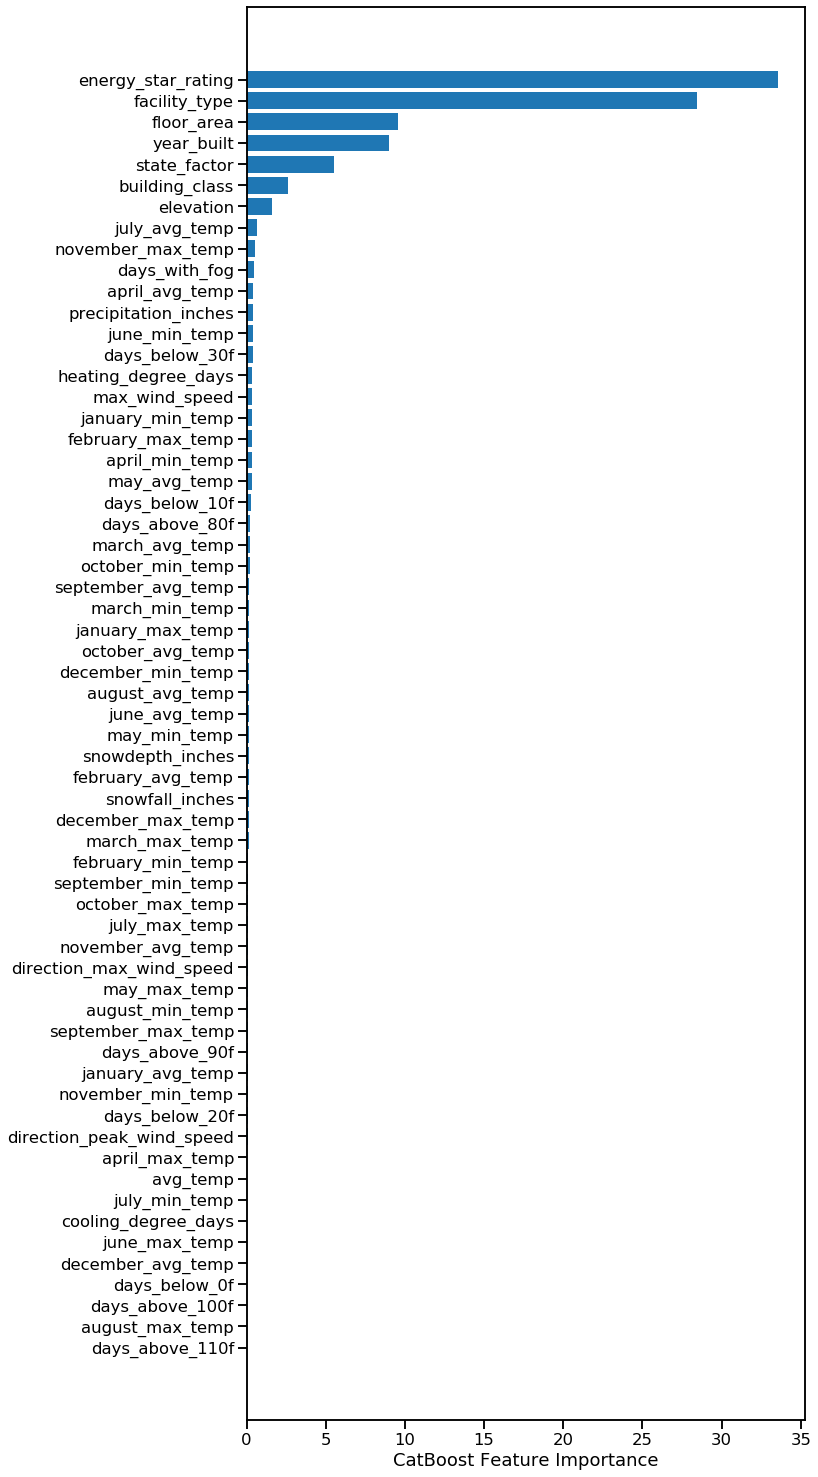

<IPython.core.display.Javascript object>

In [9]:
plot_catboost_feature_importance(model)
plt.savefig(f"{wids_path}/validation_result/{config_name}_feature_importance.png")

In [10]:
# fig, axes = plt.subplots(ncols=2, figsize=(11, 5))
# sns.barplot(data=pd.melt(catboost_rmse, id_vars=['left_out_year', 'method']),
#                  x='left_out_year', y='value', hue='variable', ax = axes[0])
# axes[0].legend([])
# sns.barplot(data=pd.melt(catboost_rmse, id_vars=['left_out_year', 'method']),
#             x='method', y='value', hue='variable', ax=axes[1])
# axes[1].legend(bbox_to_anchor=(1,1))
# plt.savefig(f"{wids_path}/validation_result/{config_name}_rmse_summary.png")

<IPython.core.display.Javascript object>

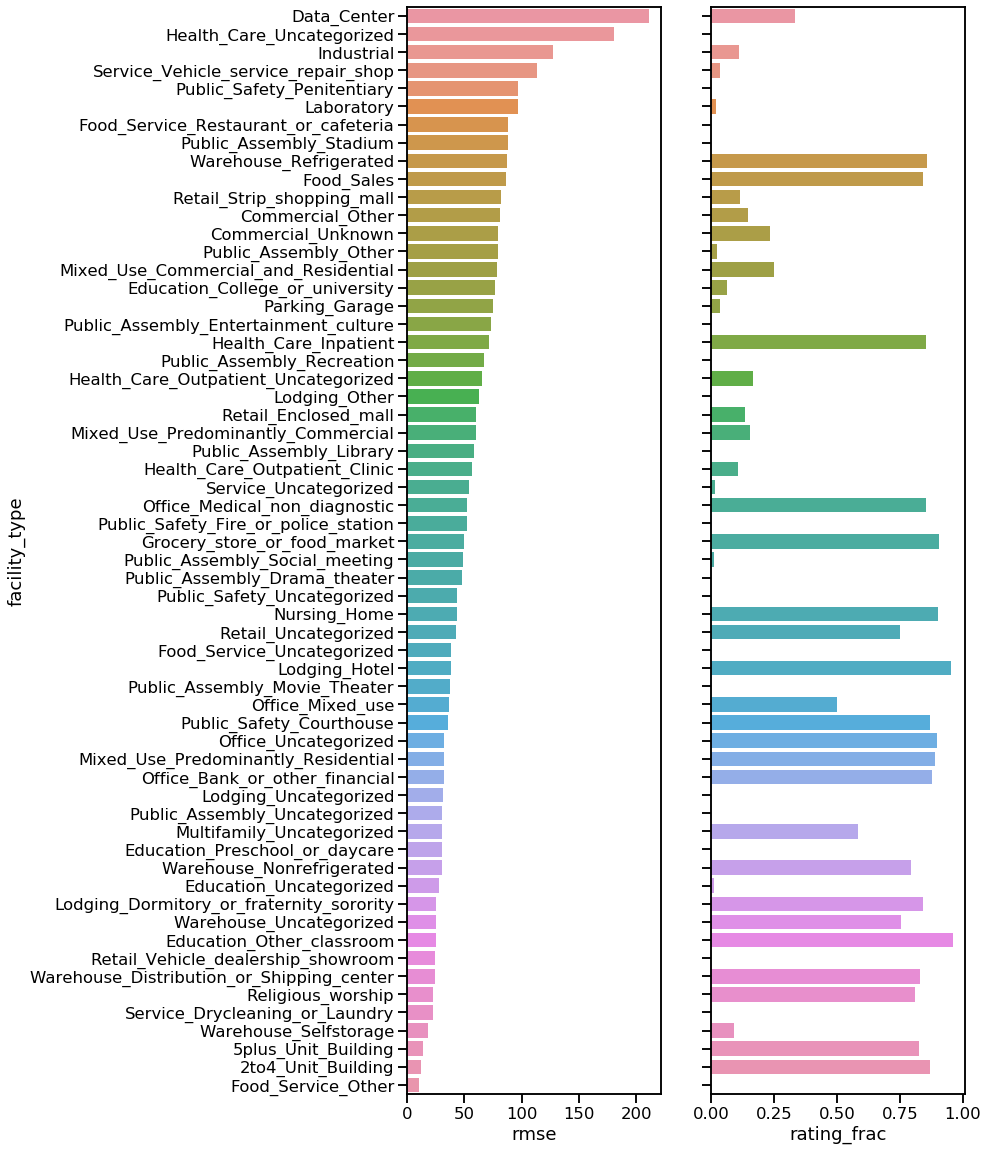

<IPython.core.display.Javascript object>

In [11]:
rmse_df = get_rmse_by_group(
    train_filter_x_df.rename(
        columns={"backfilled_energy_star_rating": "energy_star_rating"}
    ),
    train_filter_y_df,
    train_predict,
)
plot_rmse_by_group(rmse_df)
plt.savefig(f"{wids_path}/validation_result/{config_name}_rmse_by_group.png")

# Dev cells below this point

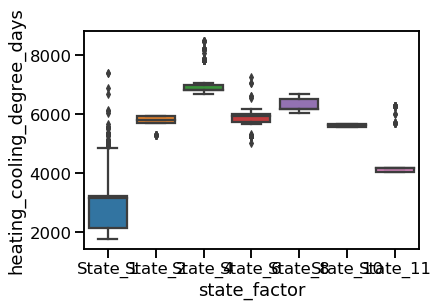

In [14]:
train_filter_df['heating_cooling_degree_days'] = train_filter_df['heating_degree_days'] + train_filter_df['cooling_degree_days']
sns.boxplot(data=train_filter_df, x='state_factor', y='heating_cooling_degree_days')

/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:1213: UserWarning: No contour levels were found within the data range.
  **contour_kws,


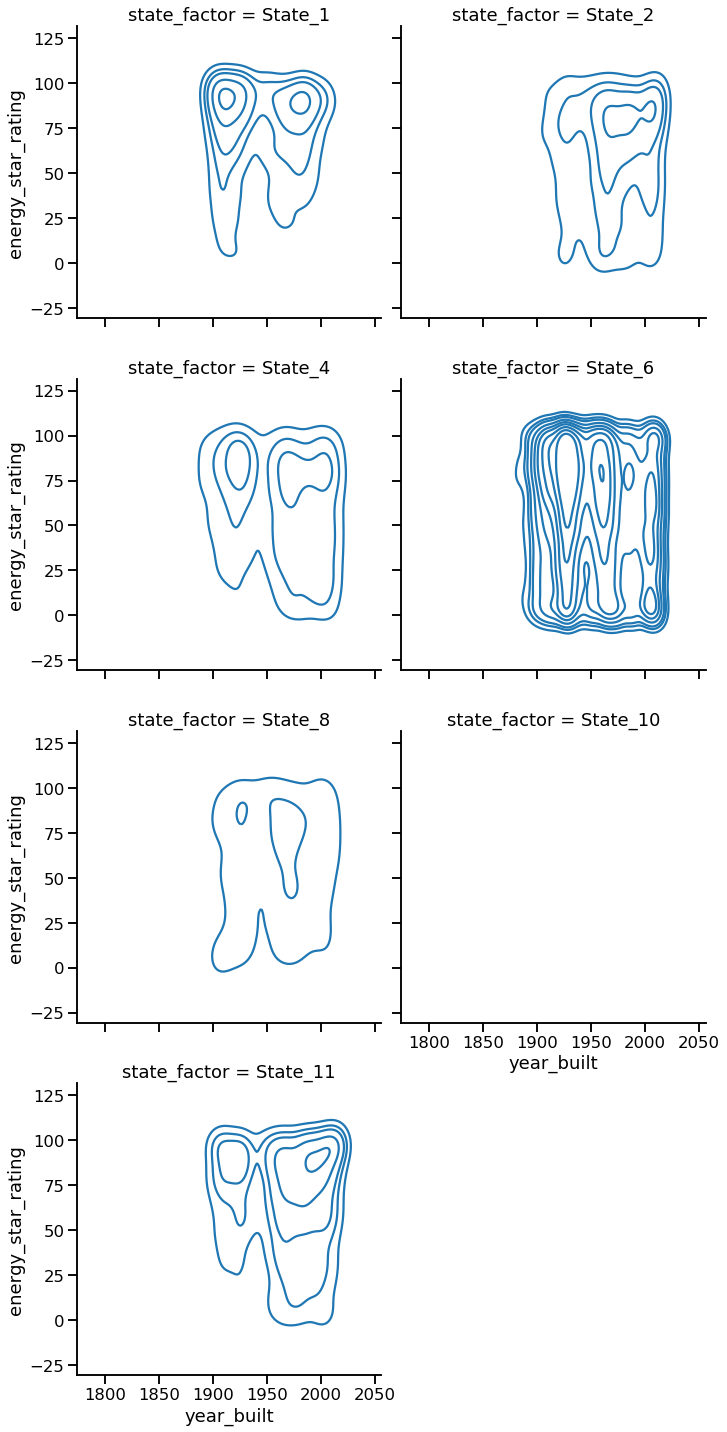

In [40]:
sns.displot(data=train_df.query("year_built>1800"), x='year_built', y='energy_star_rating', col='state_factor',
            col_wrap=2, kind='kde')

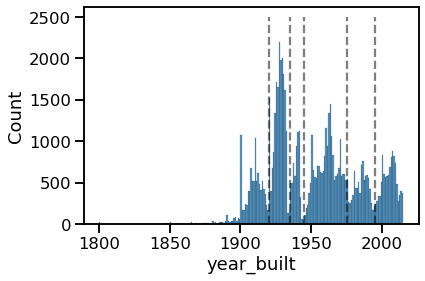

In [31]:
ax = sns.histplot(train_filter_df['year_built'], binwidth=1)
year_built_bins = [1800, 1920, 1935, 1945, 1975, 1995, 2022]
ax.vlines(year_built_bins, ymin=0, ymax=2500, linestyles='--', alpha=0.5)

# norm = plt.Normalize(train_filter_df['site_eui'].min(), train_filter_df['site_eui'].max())
# sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
# sm.set_array([])

# # Remove the legend and add a colorbar
# ax.get_legend().remove()
# ax.figure.colorbar(sm)

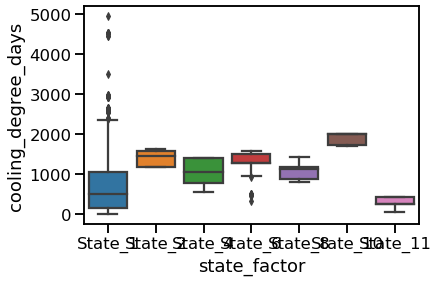

In [12]:
sns.boxplot(data=train_filter_df, x='state_factor', y='cooling_degree_days')

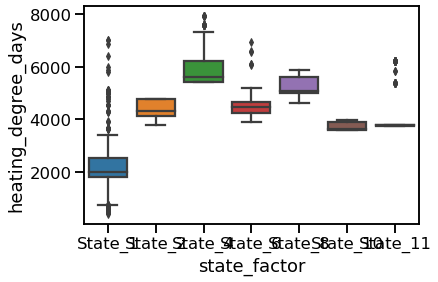

In [13]:
sns.boxplot(data=train_filter_df, x='state_factor', y='heating_degree_days')

In [7]:
merged_train_df = combine_features_and_prediction(train_filter_x_df, train_filter_y_df, train_predict)

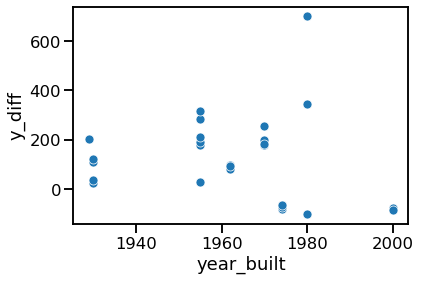

In [16]:
sns.scatterplot(data=merged_train_df.query("facility_type == 'Data_Center'"), x='year_built', y='y_diff')

In [20]:
merged_train_df.query("facility_type == 'Data_Center'")

,days_with_fog,max_wind_speed,year_built,energy_star_rating,direction_max_wind_speed,facility_type,direction_peak_wind_speed,state_factor,elevation,building_class,temp_pca1,temp_pca2,temp_pca3,temp_pca4,temp_pca5,temp_pca6,temp_pca7,temp_pca8,temp_pca9,temp_pca10,temp_pca11,log10_floor_area,y_true,y_pred,y_diff
13,NaN,1.0,1955.0,13.0,1.0,Data_Center,1.0,State_1,2.4,Commercial,9.899709,-3.664954,-2.872117,3.225393,-0.140553,-3.029312,0.462378,0.819529,-1.101217,-0.359836,0.923391,5.790140,608.839519,431.258818,177.580701
930,88.0,1.0,1955.0,14.0,1.0,Data_Center,1.0,State_1,2.4,Commercial,7.518657,3.457206,3.574886,3.848093,1.827769,-0.530686,-0.918268,-0.422340,-0.550403,-1.628838,-0.638583,5.790140,616.121303,425.027204,191.094098
1291,NaN,NaN,1955.0,19.0,NaN,Data_Center,NaN,State_1,2.4,Commercial,7.106097,3.361153,3.129690,3.997770,2.140610,1.388952,-0.196029,-0.454147,-0.178477,-1.323137,-0.558002,5.790140,656.063562,445.931537,210.132024
2505,NaN,NaN,1955.0,24.0,NaN,Data_Center,NaN,State_1,2.4,Commercial,10.970392,3.047361,-1.925137,3.131750,-0.112876,-2.462378,-0.800062,-1.030637,-0.534855,1.775066,1.415461,5.790140,752.066575,468.463168,283.603407
3599,NaN,NaN,1955.0,20.0,NaN,Data_Center,NaN,State_1,2.4,Commercial,8.413486,8.410656,4.567929,2.726743,3.824258,0.029617,2.210053,0.568842,-2.781827,-2.069750,-1.260825,5.790140,775.608943,459.798062,315.810881
4195,NaN,NaN,2000.0,NaN,NaN,Data_Center,NaN,State_1,9.1,Commercial,8.413486,8.410656,4.567929,2.726743,3.824258,0.029617,2.210053,0.568842,-2.781827,-2.069750,-1.260825,5.279190,40.395053,114.603068,-74.208015
4640,NaN,NaN,1955.0,1.0,NaN,Data_Center,NaN,State_1,2.4,Commercial,11.556235,-1.967200,-3.681439,3.868389,-0.633642,-3.298225,0.471599,-1.728747,0.185836,1.482774,0.220019,5.790140,524.064208,496.449437,27.614771
5239,NaN,NaN,2000.0,NaN,NaN,Data_Center,NaN,State_1,45.7,Commercial,11.556235,-1.967200,-3.681439,3.868389,-0.633642,-3.298225,0.471599,-1.728747,0.185836,1.482774,0.220019,5.279190,38.594262,121.418366,-82.824104
14842,12.0,1.0,1980.0,99.0,1.0,Data_Center,1.0,State_6,3.4,Commercial,-0.906130,1.185162,-0.191659,-1.535895,-0.678208,1.663895,0.557920,-1.453838,1.681902,-2.113088,0.466441,4.820077,502.542373,157.706680,344.835693
26916,93.0,1.0,1974.0,39.0,1.0,Data_Center,1.0,State_6,25.6,Commercial,-0.353112,0.033485,0.063749,-1.833425,2.561516,-1.113903,-1.056279,0.582233,0.647049,0.624359,-0.541793,6.040877,54.182890,118.480214,-64.297324
